In [1]:
import numpy as np
import os

# Imports nécessaires pour construire un modèle LeNet 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Rescaling

# Pour importer le datasets
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


# Pour la compilation du modèle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Pour visualiser les performances
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

print(tf.__version__)
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
tf.keras.backend.clear_session()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


# Chargement du dataset
#dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample"
dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample_balanced"
img_size = (224, 224)  # Taille cible
batch_size = 128
class_names = sorted(os.listdir(dir_name))
nb_class = len(class_names)

train_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="training",
    validation_split=0.2,
    seed=42
)

val_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="validation",
    validation_split=0.2,
    seed=42
)

# Ajout d'optimisation : mise en cache et préchargement
#train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

def display_results(model_history, model_name):
    # Récupérer les données d'entraînement et de validation
    train_loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]
    train_accuracy =  model_history.history["accuracy"]
    val_accuracy = model_history.history["val_accuracy"]
    
    plt.figure(figsize=(20, 8))
    
    # Tracer la perte
    plt.subplot(121)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title(model_name + ": Perte d'entraînement et de validation")
    plt.ylabel('Perte ')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    # Tracer l'erreur absolue moyenne (MAE)
    plt.subplot(122)
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.title(model_name+': Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    plt.show()

2025-03-24 08:03:19.161226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742799799.320493    3187 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742799799.366896    3187 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742799799.727947    3187 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742799799.727966    3187 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742799799.727968    3187 computation_placer.cc:177] computation placer alr

2.19.0
Num GPUs Available:  1
Found 54000 files belonging to 27 classes.
Using 43200 files for training.


I0000 00:00:1742799834.670034    3187 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 54000 files belonging to 27 classes.
Using 10800 files for validation.


In [2]:
nb_class

27

## Entrainement du modèle

Epoch 1/30


E0000 00:00:1742799956.989040    3187 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1742799960.179219    3832 cuda_dnn.cc:529] Loaded cuDNN version 90800


338/338 ━━━━━━━━━━━━━━━━━━━━ 123s 320ms/step - accuracy: 0.0885 - loss: 3.2028 - val_accuracy: 0.3411 - val_loss: 2.4460 - learning_rate: 1.0000e-04
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 106s 312ms/step - accuracy: 0.2701 - loss: 2.5307 - val_accuracy: 0.4178 - val_loss: 2.0215 - learning_rate: 1.0000e-04
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 106s 313ms/step - accuracy: 0.3524 - loss: 2.2297 - val_accuracy: 0.4575 - val_loss: 1.8588 - learning_rate: 1.0000e-04
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 105s 311ms/step - accuracy: 0.3940 - loss: 2.0799 - val_accuracy: 0.4827 - val_loss: 1.7697 - learning_rate: 1.0000e-04
Epoch 5/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 105s 311ms/step - accuracy: 0.4238 - loss: 1.9710 - val_accuracy: 0.4938 - val_loss: 1.7125 - learning_rate: 1.0000e-04
Epoch 6/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 105s 311ms/step - accuracy: 0.4428 - loss: 1.8955 - val_accuracy: 0.5111 - val_loss: 1.6461 - learning_rate: 1.0000e-04
Epoch 7/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 105s 311ms/

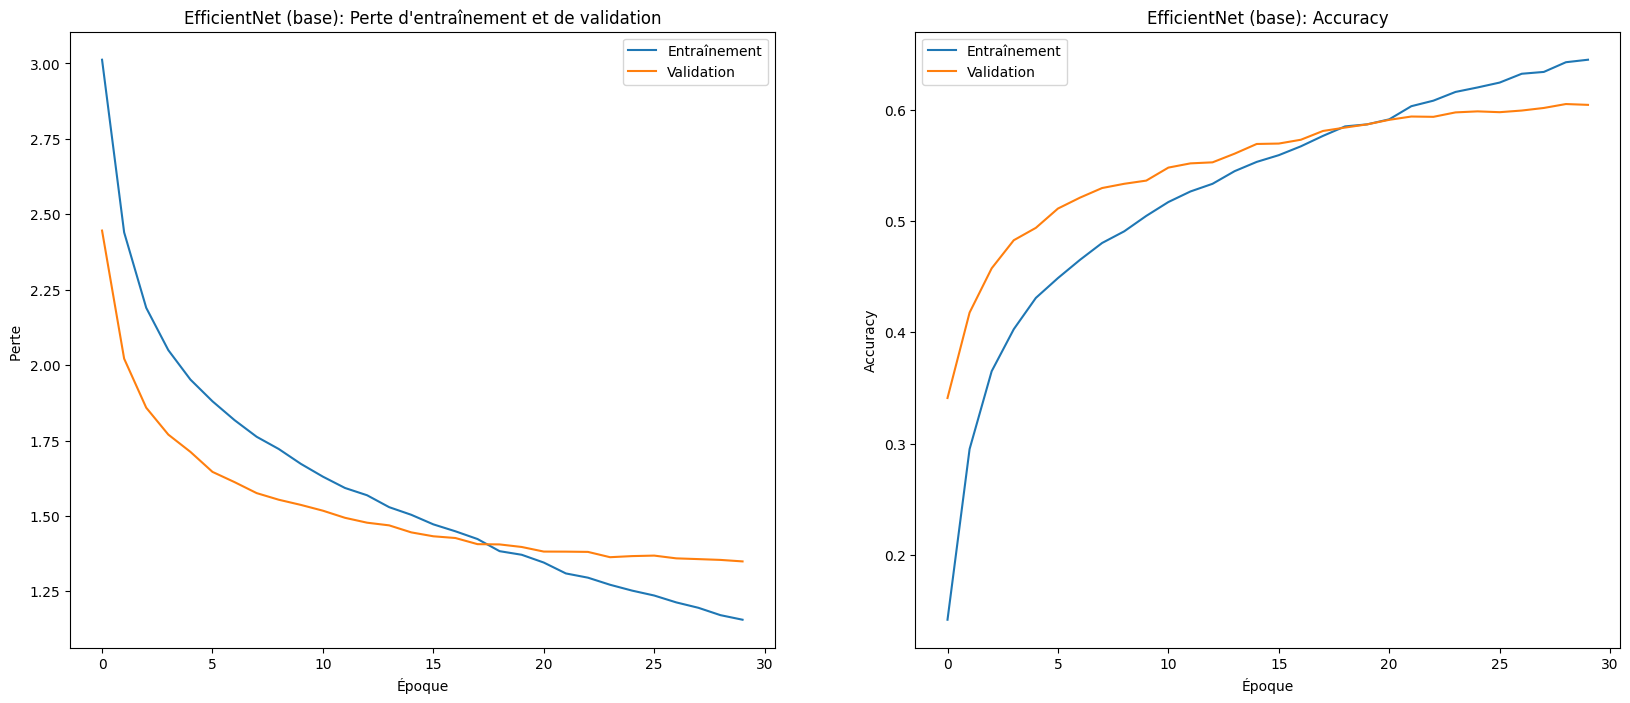

Analyse performance


In [3]:
import tensorflow as tf 
# 1. Choisir un modèle préentraîné
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
#base_model.trainable = False  # Geler d'abord le modèle de base

# Dégeler les dernières couches du modèle de base
base_model.trainable = False

# Geler les dernières couches
for layer in base_model.layers[-30:]:
    layer.trainable = True
    
# 2. Construire le modèle complet

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

model = tf.keras.Sequential([
    # Augmentation de données
    data_augmentation,

     # Prétraitement spécifique au modèle
    tf.keras.layers.Lambda(lambda x: tf.keras.applications.efficientnet.preprocess_input(x)),
    #tf.keras.layers.Rescaling(1./255),  

    # Modèle de base
    base_model,

    # Couches de classification
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(nb_class, activation='softmax')
])

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

model.compile(
    loss='sparse_categorical_crossentropy',  
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),                 
    metrics=['accuracy'])  

model_history = model.fit(train_ds,           
                           validation_data=val_ds,
                           epochs=30,
                           callbacks=[lr_reducer, early_stopping])  

# Analyse de l'entainement
print("Analyse entraintement")
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Précision de validation finale: {val_accuracy:.4f}")
display_results(model_history, "EfficientNet (base)")

# Analyse de la performance
print("Analyse performance")

## Analyse de la performance par classe

In [4]:
### ANALYSE DE LA PERFORMACE ###

# 1. Générer des prédictions sur l'ensemble de validation
# Prévoir les classes pour tous les échantillons de validation
predictions = []
labels = []

# Récupérer toutes les étiquettes et prédictions
for images, true_labels in val_ds:
    pred = model.predict(images)
    pred_classes = np.argmax(pred, axis=1)
    
    predictions.extend(pred_classes)
    labels.extend(true_labels.numpy())

# Convertir en arrays numpy
predictions = np.array(predictions)
labels = np.array(labels)

# 2. Créer et afficher la matrice de confusion
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de confusion')
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━

2025-03-24 09:00:30.753030: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


NameError: name 'sns' is not defined

<Figure size 1000x800 with 0 Axes>